In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from scipy.stats import pearsonr

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Explore the data directory for RMSD files
print("Scanning ../data/ for RMSD files...")
data_dir = '../data/'
rmsd_files = []

for file in os.listdir(data_dir):
    if file.endswith('_rmsd.txt') or (file.endswith('.xvg') and 'rmsd' in file.lower()):
        rmsd_files.append(file)
        print(f"Found: {file}")

print(f"\nTotal RMSD files found: {len(rmsd_files)}")
rmsd_files.sort()
print("Sorted file list:", rmsd_files)

Scanning ../data/ for RMSD files...
Found: ak_rmsd1_250ns.xvg
Found: lipa_rmsd2_250ns.xvg
Found: onc_md_run2_rmsd.xvg
Found: onc_md_run3_rmsd.xvg
Found: hiv_rmsd2_135ns.xvg
Found: ak_rmsd3_250ns.xvg
Found: hiv_af_rmsd.txt
Found: onc_md_run1_rmsd.xvg
Found: ak_rmsd2_236ns.xvg
Found: onc_af_rmsd.txt
Found: lipa_rmsd1_250ns.xvg
Found: hiv_rmsd3_100ns.xvg
Found: lipa_af_rmsd.txt
Found: ak_af_rmsd.txt
Found: hiv_rmsd1_250ns.xvg

Total RMSD files found: 15
Sorted file list: ['ak_af_rmsd.txt', 'ak_rmsd1_250ns.xvg', 'ak_rmsd2_236ns.xvg', 'ak_rmsd3_250ns.xvg', 'hiv_af_rmsd.txt', 'hiv_rmsd1_250ns.xvg', 'hiv_rmsd2_135ns.xvg', 'hiv_rmsd3_100ns.xvg', 'lipa_af_rmsd.txt', 'lipa_rmsd1_250ns.xvg', 'lipa_rmsd2_250ns.xvg', 'onc_af_rmsd.txt', 'onc_md_run1_rmsd.xvg', 'onc_md_run2_rmsd.xvg', 'onc_md_run3_rmsd.xvg']


In [44]:
# Load and organize RMSD data by protein target
def load_rmsd_file(filepath):
    """Load RMSD data from file, handling Gromacs XVG and other formats"""
    try:
        if filepath.endswith('.xvg'):
            # Handle Gromacs XVG files (skip comment and header lines)
            data = []
            with open(filepath, 'r') as f:
                for line in f:
                    line = line.strip()
                    # Skip comments and headers
                    if line.startswith('#') or line.startswith('@') or not line:
                        continue
                    # Parse data lines
                    parts = line.split()
                    if len(parts) >= 2:
                        try:
                            time_val = float(parts[0])  # Time in ps
                            rmsd_val = float(parts[1])  # RMSD in nm (convert to Angstrom)
                            data.append([time_val, rmsd_val * 10])  # Convert nm to Angstrom
                        except ValueError:
                            continue
            
            if data:
                data = np.array(data)
                return data[:, 0], data[:, 1]  # time, rmsd
            else:
                print(f"No valid data found in {filepath}")
                return None, None
        
        else:
            # Handle regular text files
            try:
                # Try loading with pandas first
                data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')
                if data.shape[1] >= 2:
                    return data.iloc[:, 0].values, data.iloc[:, 1].values  # time, rmsd
                else:
                    # If only one column, assume it's RMSD and create time points
                    rmsd_values = data.iloc[:, 0].values * 10. #to convert from nm to Angstrom
                    time_values = np.linspace(0, 250, len(rmsd_values))
                    return time_values, rmsd_values
            except:
                # Fallback to numpy
                data = np.loadtxt(filepath)
                if data.ndim == 2 and data.shape[1] >= 2:
                    return data[:, 0], data[:, 1]
                else:
                    return np.arange(len(data)), data
    
    except Exception as e:
        print(f"Could not load {filepath}: {e}")
        return None, None

# Organize data by protein target
protein_data = {
    'AK': {'af3': None, 'md_runs': []},
    'HIV': {'af3': None, 'md_runs': []},
    'LipA': {'af3': None, 'md_runs': []},
    'Onconase': {'af3': None, 'md_runs': []}
}

# Load all RMSD files
print("Loading RMSD files...")
for file in rmsd_files:
    filepath = os.path.join(data_dir, file)
    time_vals, rmsd_vals = load_rmsd_file(filepath)
    
    if time_vals is not None and rmsd_vals is not None:
        print(f"Loaded {file}: {len(rmsd_vals)} data points")
        
        # Classify by protein target and type
        file_lower = file.lower()
        
        # Determine protein target
        if 'ak' in file_lower:
            target = 'AK'
        elif 'hiv' in file_lower:
            target = 'HIV'
        elif 'lipa' in file_lower or 'lipase' in file_lower:
            target = 'LipA'
        elif 'onc' in file_lower:
            target = 'Onconase'
        else:
            print(f"Unknown protein target in file: {file}")
            continue
        
        # Determine data type (AF3 vs MD)
        if 'af' in file_lower:
            protein_data[target]['af3'] = (time_vals, rmsd_vals, file)
        elif ('md' in file_lower) or ('rmsd1' in file_lower) or ('rmsd2' in file_lower) or ('rmsd3' in file_lower):
            protein_data[target]['md_runs'].append((time_vals, rmsd_vals, file))
        else:
            print(f"Could not classify file type: {file}")

# Print summary of loaded data
print("\nData summary:")
for protein, data in protein_data.items():
    af3_status = "✓" if data['af3'] is not None else "✗"
    md_count = len(data['md_runs'])
    print(f"{protein}: AF3 {af3_status}, MD runs: {md_count}")
    if data['af3']:
        print(f"  AF3: {data['af3'][2]}")

    for i, (_, _, filename) in enumerate(data['md_runs']):
        print(f"  MD{i+1}: {filename}")

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9n/kbxcs17x681cnz5lqncq2ktc0000gp/T/ipykernel_15091/1306662687.py:35: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(filepath, sep='\s+', header=None, comment='#')


Loading RMSD files...
Loaded ak_af_rmsd.txt: 101 data points
Loaded ak_rmsd1_250ns.xvg: 25001 data points
Loaded ak_rmsd2_236ns.xvg: 23608 data points
Loaded ak_rmsd3_250ns.xvg: 25001 data points
Loaded hiv_af_rmsd.txt: 101 data points
Loaded hiv_rmsd1_250ns.xvg: 25001 data points
Loaded hiv_rmsd2_135ns.xvg: 13492 data points
Loaded hiv_rmsd3_100ns.xvg: 10001 data points
Loaded lipa_af_rmsd.txt: 101 data points
Loaded lipa_rmsd1_250ns.xvg: 25001 data points
Loaded lipa_rmsd2_250ns.xvg: 25001 data points
Loaded onc_af_rmsd.txt: 101 data points
Loaded onc_md_run1_rmsd.xvg: 25001 data points
Loaded onc_md_run2_rmsd.xvg: 25001 data points
Loaded onc_md_run3_rmsd.xvg: 25001 data points

Data summary:
AK: AF3 ✓, MD runs: 3
  AF3: ak_af_rmsd.txt
  MD1: ak_rmsd1_250ns.xvg
  MD2: ak_rmsd2_236ns.xvg
  MD3: ak_rmsd3_250ns.xvg
HIV: AF3 ✓, MD runs: 3
  AF3: hiv_af_rmsd.txt
  MD1: hiv_rmsd1_250ns.xvg
  MD2: hiv_rmsd2_135ns.xvg
  MD3: hiv_rmsd3_100ns.xvg
LipA: AF3 ✓, MD runs: 2
  AF3: lipa_af_rmsd.tx

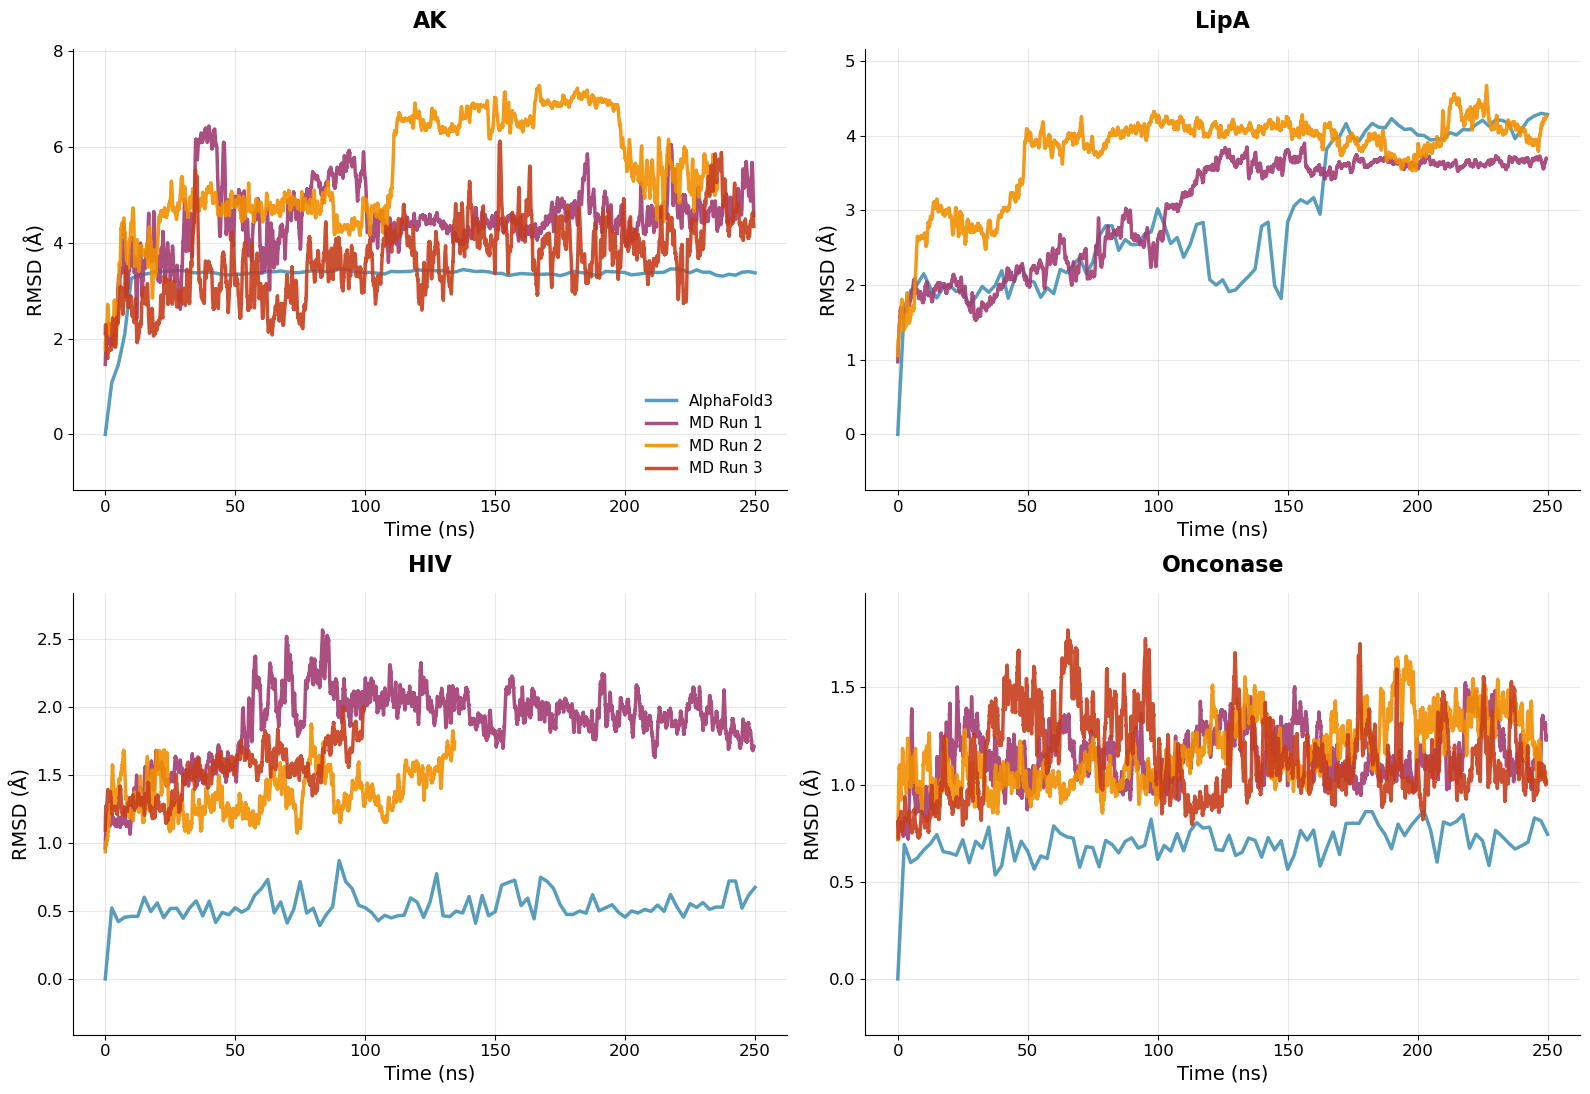

In [52]:
# Create 2x2 panel figure with RMSD plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
#fig.suptitle('RMSD Analysis: AlphaFold3 vs MD Simulations', fontsize=20, fontweight='bold')

# Color scheme
af3_color = '#2E86AB'  # Blue for AF3
md_colors = ['#A23B72', '#F18F01', '#C73E1D']  # Different colors for MD runs

# Plot data for each protein target
targets = ['AK', 'LipA', 'HIV', 'Onconase']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, (target, pos) in enumerate(zip(targets, positions)):
    ax = axes[pos]
    data = protein_data[target]
    
    # Plot AF3 data
    if data['af3'] is not None:
        time_vals, rmsd_vals, filename = data['af3']
        # Convert time to ns if needed (assuming time is in ps)
        time_ns = time_vals / 1000 if np.max(time_vals) > 1000 else time_vals
        ax.plot(time_ns, rmsd_vals, color=af3_color, linewidth=2.5, 
                label='AlphaFold3', alpha=0.8)
    
    # Plot MD runs
    for j, (time_vals, rmsd_vals, filename) in enumerate(data['md_runs']):
        # Convert time to ns if needed
        time_ns = time_vals / 1000 if np.max(time_vals) > 1000 else time_vals
        color = md_colors[j % len(md_colors)]

        # Smooth RMSD values over 10 adjacent frames using a moving average
        window = 50
        if len(rmsd_vals) >= window:
            rmsd_smoothed = np.convolve(rmsd_vals, np.ones(window)/window, mode='valid')
            # Adjust time to match the length of smoothed data
            time_smoothed = time_ns[:len(rmsd_smoothed)]
        else:
            rmsd_smoothed = rmsd_vals
            time_smoothed = time_ns

        ax.plot(time_smoothed, rmsd_smoothed, color=color, linewidth=2.5, 
                label=f'MD Run {j+1}', alpha=0.9)

        #ax.plot(time_ns, rmsd_vals, color=color, linewidth=1.8, 
        #        label=f'MD Run {j+1}', alpha=0.7)
    
    # Customize subplot
    ax.set_title(f'{target}', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Time (ns)', fontsize=14)
    ax.set_ylabel('RMSD (Å)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Show legend only on first plot (AK)
    if pos == (0, 0):  # Top-left position
        ax.legend(fontsize=11, frameon=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Set axis limits and ticks
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Add some padding to y-axis
    if len(ax.get_lines()) > 0:
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))

# All subplots now filled with data - no empty subplot handling needed

# Adjust layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./rmsd_analysis.pdf', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
fig.savefig('./rmsd_analysis.pdf', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()
